# VGG16 Implementation with Old LC on MNIST

In [1]:
import glob
import sys
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import scipy as spy
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import ssl
import pickle, json
import src.main as lc
import old_lc.main as olc
from src.models.VGG16NoLite import VGG16NoLite
import src.compression.deltaCompress as lc_compress
from src.models.VGG16NoLite_LowRank import getBase, VGG16NoLite_LowRank, load_sd_decomp
from src.utils.utils import evaluate_accuracy, evaluate_accuracy_gpu, lazy_restore,lazy_restore_gpu, evaluate_compression
import torchvision

c:\Users\Bradf\anaconda3\envs\py310\lib\site-packages\transformers\utils\generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
# Create the VGG16NoLite model
model = VGG16NoLite()

# Function to count the number of parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    
    # Exclude the last nn.Linear layer
    linear_params = 0
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            linear_params += sum(p.numel() for p in module.parameters())

    return total_params, linear_params

# Get the total and linear parameters
total_params, linear_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Linear parameters (for LoRA): {linear_params}")

Total parameters: 134326346
Linear parameters (for LoRA): 119586826


## Definition of Data Loader function

In [4]:
# HDFP = "./volumes/Ultra Touch" # Load HHD

# def data_loader():
#     transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(32, antialias=True)])

#     trainset = datasets.MNIST(root='./data', train=True,
#                                           download=True, transform=transform)
#     # Reintroduce the 2000 datapoints model has not seen before.
#     trainset.data = trainset.data.clone()[-2000:-1000]
#     trainset.targets = trainset.targets.clone()[-2000:-1000]
#     trainloader = torch.utils.data.DataLoader(trainset, batch_size = 32,
#                                               shuffle=False, num_workers=2)

#     testset = datasets.MNIST(root='./data', train=False,
#                                          download=True, transform=transform)

#     testset.data = trainset.data[-1000:]
#     testset.targets = trainset.targets[-1000:]
#     testloader = torch.utils.data.DataLoader(testset, batch_size = 32,
#                                              shuffle=False, num_workers=2)
    
#     testloader = torch.utils.data.DataLoader(testset, batch_size = 32,
#                                              shuffle=False, num_workers=2)
    
#     return trainloader, testloader

HDFP = "./volumes/Ultra Touch"  # Placeholder for HDD path

def data_loader():
    # Définir les transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Redimensionner l'image à 224x224
        transforms.Grayscale(num_output_channels=3),  # Convertir l'image en niveaux de gris à une image à 3 canaux
        transforms.ToTensor(),  # Convertir en tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normaliser avec les moyennes et écarts-types du pré-entraînement de VGG
    ])

    # Charger le dataset d'entraînement MNIST
    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    # trainset.data = trainset.data.clone()[-7000:]
    # trainset.targets = trainset.targets.clone()[-7000:]
    # trainset.data = trainset.data.clone()[-64:]
    # trainset.targets = trainset.targets.clone()[-64:]
    trainset.data = trainset.data.clone()[-2000:-1000]
    trainset.targets = trainset.targets.clone()[-2000:-1000]
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

    # Charger le dataset de test MNIST
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # testset.data = trainset.data.clone()[-32:]
    # testset.targets = trainset.targets.clone()[-32:]
    testset.data = trainset.data.clone()[-1000:]
    testset.targets = trainset.targets.clone()[-1000:]
    test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)
    
    return train_loader, test_loader


# def data_loader():
#     transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,))
#     ])

#     # Load the MNIST training dataset
#     trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
#     # Use the last 10,000 images for training
#     trainset.data = trainset.data.clone()[-1000:]
#     trainset.targets = trainset.targets.clone()[-1000:]
#     # trainset.data = trainset.data.clone()[-58000:]
#     # trainset.targets = trainset.targets.clone()[-58000:]
#     train_loader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

#     # Load the MNIST test dataset
#     testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
#     # Use the first 1,000 images from the test dataset
#     testset.data = testset.data.clone()[:300]
#     testset.targets = testset.targets.clone()[:300]
#     test_loader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
    
#     return train_loader, test_loader

## Calling MNIST dataset

In [5]:
# Bypass using SSL unverified
ssl._create_default_https_context = ssl._create_unverified_context
# MNIST dataset 
train_loader, test_loader = data_loader()

## Bypass the matplotlib error

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Showing some images of the dataset we use

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


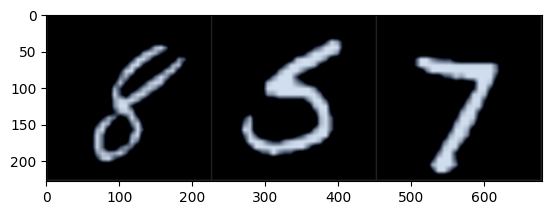

tensor(8) tensor(5) tensor(7)


In [7]:
# Adjust these values to match the normalization values used during the loading of your dataset
mean = 0.1307
std = 0.3081

# Function to show an image
def imshow(img):
    # Adjusting unnormalization for potentially 3-channel images
    img = img * std + mean  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Assuming train_loader is defined and loaded as before
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:3]))
# Print labels
print(' '.join('%5s' % labels[j] for j in range(3)))


## Creation of folder to save the results (for plots and compression rate)

In [8]:
SAVE_LOC = HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/vgg16nolite/lobranch"
if not os.path.exists(SAVE_LOC):
    os.makedirs(SAVE_LOC)

SAVE_LOC_OLC = HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/vgg16nolite/old-lc"
if not os.path.exists(SAVE_LOC_OLC):
    os.makedirs(SAVE_LOC_OLC)

## Definition of the accuracy functions

In [9]:
def accuracy_binary(model, evaluation_set):
    model.eval()  # Switches the model to evaluation mode.

    no_correct, no_seen = 0, 0  # Initialize counters for correct predictions and total samples seen.

    with torch.no_grad():  # Disables gradient calculation.
        for input, label in evaluation_set:  # Iterate over the evaluation dataset.
            output = torch.sigmoid(model(input))  # Apply sigmoid to model output to get probabilities.
            output = torch.where(output > 0.5, 1, 0)  # Threshold probabilities at 0.5 to decide between classes 0 and 1.
            no_seen += label.size(0)  # Count the number of samples seen (batch size).
            no_correct += (output == label).sum().item()  # Increment correct predictions by the number of matches in the batch.
    
    acc = no_correct / no_seen  # Calculate accuracy as the ratio of correct predictions to total samples.
    model.train()  # Switch the model back to training mode.
    return acc  # Return the computed accuracy.

def accuracy_multiclass(model, evaluation_set):
    model.eval()  # Switches the model to evaluation mode.

    no_correct, no_seen = 0, 0  # Initialize counters for correct predictions and total samples seen.

    with torch.no_grad():  # Disables gradient calculation.
        for input, label in evaluation_set:  # Iterate over the evaluation dataset.
            output = model(input)  # Get the raw logits from the model.
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max logit which represents the predicted class.
            no_seen += label.size(0)  # Count the number of samples seen (batch size).
            no_correct += pred.eq(label.view_as(pred)).sum().item()  # Compare predictions with true labels and sum up correct predictions.
    
    acc = no_correct / no_seen  # Calculate accuracy as the ratio of correct predictions to total samples.
    model.train()  # Switch the model back to training mode.
    return acc  # Return the computed accuracy.


## Special function for the accuracy of the model on GPU 

In [10]:
def accuracy_multiclass_gpu(model, evaluation_set):
    device = next(model.parameters()).device  # Get the device of the model
    model.eval()  # Switches the model to evaluation mode.

    no_correct, no_seen = 0, 0  # Initialize counters for correct predictions and total samples seen.

    with torch.no_grad():  # Disables gradient calculation.
        for inputs, labels in evaluation_set:  # Iterate over the evaluation dataset.
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device of the model
            output = model(inputs)  # Get the raw logits from the model.
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max logit which represents the predicted class.
            no_seen += labels.size(0)  # Count the number of samples seen (batch size).
            no_correct += pred.eq(labels.view_as(pred)).sum().item()  # Compare predictions with true labels and sum up correct predictions.
    
    acc = no_correct / no_seen  # Calculate accuracy as the ratio of correct predictions to total samples.
    model.train()  # Switch the model back to training mode.
    return acc  # Return the computed accuracy.


## On GPU (Testing if it works with loss)

In [ ]:
# get the base model (VGG16NoLite)

model_for_checkpoint = VGG16NoLite()


# train model_for_checkpoint such that we compute the loss for the validation dataset and the training dataset (just for the sake of it), et take the checkpoint at the minimum validation loss

# define the loss function

criterion = nn.CrossEntropyLoss()

# define the optimizer

optimizer = torch.optim.SGD(model_for_checkpoint.parameters(), lr=0.001, momentum=0.9)

# define the number of epochs

n_epochs = 5

# define the validation loss

valid_loss_min = np.Inf

# GPU check with print

if torch.cuda.is_available():
    print("GPU available")

else:
    print("GPU not available")

    
# move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# move the model to the GPU

model_for_checkpoint.to(device)

# train the model

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0

    model_for_checkpoint.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model_for_checkpoint(data)

        loss = criterion(output, target)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()*data.size(0)

    model_for_checkpoint.eval()

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        output = model_for_checkpoint(data)

        loss = criterion(output, target)

        valid_loss += loss.item()*data.size(0)

    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(test_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, valid_loss))
        # torch.save(model_for_checkpoint.state_dict(), 'model_for_checkpoint.pt')
        valid_loss_min = valid_loss

## On CPU (Testing if it works with loss)

In [ ]:
# # get the base model (VGG16NoLite)

# model_for_checkpoint = VGG16NoLite()


# # train model_for_checkpoint such that we compute the loss for the validation dataset and the training dataset (just for the sake of it), et take the checkpoint at the minimum validation loss

# # define the loss function

# criterion = nn.CrossEntropyLoss()

# # define the optimizer

# optimizer = torch.optim.SGD(model_for_checkpoint.parameters(), lr=0.001, momentum=0.9)

# # define the number of epochs

# n_epochs = 10

# # define the validation loss

# valid_loss_min = np.Inf

# # train the model

# for epoch in range(1, n_epochs+1):
#     train_loss = 0.0
#     valid_loss = 0.0

#     model_for_checkpoint.train()
#     for data, target in train_loader:
#         optimizer.zero_grad()
#         output = model_for_checkpoint(data)
#         loss = criterion(output, target)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()*data.size(0)

#     model_for_checkpoint.eval()
#     for data, target in test_loader:
#         output = model_for_checkpoint(data)
#         loss = criterion(output, target)
#         valid_loss += loss.item()*data.size(0)

#     train_loss = train_loss/len(train_loader.sampler)
#     valid_loss = valid_loss/len(test_loader.sampler)

#     print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

#     if valid_loss <= valid_loss_min:
#         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
#         # torch.save(model_for_checkpoint.state_dict(), SAVE_LOC + '/model.pt')
#         valid_loss_min = valid_loss

## Usual training on GPU (Creating branchpoints)

In [ ]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# get the base model (VGG16NoLite) and move it to the chosen device
model_for_checkpoint = VGG16NoLite().to(device)

# creating branchpoints
epochs = 20
isLoop = True
optimizer = torch.optim.SGD(model_for_checkpoint.parameters(), lr=0.01)  # momentum=0.9

for epoch in range(epochs):
    for iter, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device

        optimizer.zero_grad()
        outputs = model_for_checkpoint(inputs)

        # Here assuming your loss function and any other operation are compatible with CUDA tensors
        loss = torch.nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

        if iter % 20 == 0:
            print("Running validation for {} Epoch, {} Iteration...".format(epoch, iter))
            res = accuracy_multiclass_gpu(model_for_checkpoint, test_loader)  # Ensure this function also handles data on GPU

            print("ACCURACY: {}".format(res))
            if res > 0.7:
                # Move model to CPU before saving
                model_for_checkpoint.to('cpu')
                torch.save(model_for_checkpoint.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/vgg16nolite/branch_{}.pt".format(res))
                # Optionally, move model back to the original device (GPU) if further computation is needed
                model_for_checkpoint.to(device)
            if res > 0.9:
                isLoop = False
                break
    if not isLoop:
        break
    print("Length of train_loader is: ", len(train_loader))


## Usual training on CPU (Creating branchpoints)

In [ ]:
# get the base model (VGG16NoLite)

model_for_checkpoint = VGG16NoLite()

# creating branchpoints : 

epochs = 10
isLoop = True
optimizer = torch.optim.SGD(model_for_checkpoint.parameters(), lr=0.001, momentum=0.9) # momentum=0.9

for epoch in range(epochs):
    for iter, data in enumerate(train_loader):
        inputs, labels = data
        # print(inputs, labels)
        optimizer.zero_grad()
        outputs = model_for_checkpoint(inputs)

        # if self.config.loss_function == "binary_cross_entropy":
        #     outputs = torch.sigmoid(outputs)
        
        # loss = loss_function(outputs, labels)
        loss = torch.nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

        # print("Epoch {} | Iteration {} : Loss {}".format(epoch, iter, loss.item()))
        if iter % 20 == 0:
            print("Running validation for {} Epoch, {} Iteration...".format(epoch, iter))
            # Previously: res = accuracy_binary(model_for_checkpoint, test_loader)
            res = accuracy_multiclass(model_for_checkpoint, test_loader)

            # res = accuracy_binary(model_for_checkpoint, test_loader)
            
            print("ACCURACY: {}".format(res))
            if res > 0.7:
                torch.save(model_for_checkpoint.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/vgg16nolite/branch_{}.pt".format(res))
            if res > 0.9:
                isLoop = False
                break
    if not isLoop:
        break
    print("Length of train_loader is: ", len(train_loader))

## Exploiting branchpoints of the model

### Call of the different models to compare

In [11]:
DECOMPOSED_LAYERS = ['classifier.0.weight', 'classifier.4.weight', 'classifier.8.weight']
RANK = -1
SCALING = -1
BRANCH_ACC = "0.831"

# Set up weights for original VGG16 model
original = VGG16NoLite()
model_original = VGG16NoLite()

# Load from "branch point"
BRANCH_LOC = HDFP + "/lobranch-snapshot/branchpoints/vgg16nolite/branch_{}.pt".format(BRANCH_ACC)
original.load_state_dict(torch.load(BRANCH_LOC))
model_original.load_state_dict(torch.load(BRANCH_LOC))


<All keys matched successfully>

### Whole state of the model

In [12]:
model_original.state_dict().keys()

odict_keys(['feature.0.weight', 'feature.0.bias', 'feature.1.weight', 'feature.1.bias', 'feature.1.running_mean', 'feature.1.running_var', 'feature.1.num_batches_tracked', 'feature.3.weight', 'feature.3.bias', 'feature.4.weight', 'feature.4.bias', 'feature.4.running_mean', 'feature.4.running_var', 'feature.4.num_batches_tracked', 'feature.7.weight', 'feature.7.bias', 'feature.8.weight', 'feature.8.bias', 'feature.8.running_mean', 'feature.8.running_var', 'feature.8.num_batches_tracked', 'feature.10.weight', 'feature.10.bias', 'feature.11.weight', 'feature.11.bias', 'feature.11.running_mean', 'feature.11.running_var', 'feature.11.num_batches_tracked', 'feature.14.weight', 'feature.14.bias', 'feature.15.weight', 'feature.15.bias', 'feature.15.running_mean', 'feature.15.running_var', 'feature.15.num_batches_tracked', 'feature.17.weight', 'feature.17.bias', 'feature.18.weight', 'feature.18.bias', 'feature.18.running_mean', 'feature.18.running_var', 'feature.18.num_batches_tracked', 'featur

### Get the weights and bias as the base for the LoRA version of custom linear layers

In [13]:
w, b = getBase(model_original)

### Paying attention to the bias shape if it is a column vector

In [14]:
for bias in b:
    print(bias.shape)

torch.Size([4096])
torch.Size([4096])
torch.Size([10])


### Having a LoRA version of the model with the weight and bias of the custom linear layers

In [15]:
model = VGG16NoLite_LowRank(w, b, rank = RANK)

### Loading and updating model state dictionary from Checkpoint

In [16]:
#########################################################################
# load_sd_decomp(org_sd, model, decomposed_layers):                     #
#     """                                                               #                          
#     @param org_sd : The state_dict when the model is ongoing.         #
#     @param model : The decomp model with decomposed layers.           #
#     @param decomposed_layers : The decomposed layers in decomp model. #
#                                                                       #
#     @return The new model with the old state dictionary loaded in.    #
#     """                                                               #
#     new_sd = model.state_dict()                                       #
#     for k, v in org_sd.items():                                       #
#         if k not in decomposed_layers:                                #
#             new_sd[k] = v                                             #
#     model.load_state_dict(new_sd)                                     #
#########################################################################

# Create a new state dictionary for the model
new_sd = model.state_dict()

# Load the state dictionary from the checkpoint file located at BRANCH_LOC
for k, v in torch.load(BRANCH_LOC).items():

    # Uncomment to print the keys from the loaded state dictionary
    # print(k)

    # Check if the key is not in DECOMPOSED_LAYERS
    if k not in DECOMPOSED_LAYERS:
        # If the key is not in DECOMPOSED_LAYERS, assign the value v to the corresponding key k in the new state dictionary
        new_sd[k] = v

# Print the updated state dictionary
print(new_sd)

# Load the updated state dictionary into the model
model.load_state_dict(new_sd)


OrderedDict([('feature.0.weight', tensor([[[[ 2.0949e-02, -1.9694e-01,  9.3853e-02],
          [ 8.7904e-02,  4.8286e-02,  8.9047e-02],
          [-7.4843e-02, -1.5372e-01, -1.6142e-01]],

         [[ 3.1408e-02, -1.8290e-02,  6.0699e-02],
          [-1.0508e-01, -4.2256e-02, -8.2979e-02],
          [ 6.6161e-02, -9.7645e-03, -1.9598e-01]],

         [[ 6.2009e-02, -1.0411e-01, -1.1494e-01],
          [ 6.5189e-02, -4.2194e-02,  2.8435e-02],
          [-7.0448e-02, -9.5367e-02, -1.9152e-01]]],


        [[[ 1.3520e-01, -1.6942e-01,  1.2106e-01],
          [-9.9631e-02,  1.3616e-01,  1.2055e-01],
          [ 3.6884e-02,  1.4935e-02,  1.5945e-01]],

         [[ 2.6459e-02,  1.2740e-01, -1.5796e-01],
          [-1.4489e-01,  7.9418e-02,  1.8630e-01],
          [-5.4855e-02,  5.7058e-03, -1.9116e-02]],

         [[ 5.5389e-02, -5.9575e-02, -7.3403e-02],
          [-1.1678e-01, -2.5260e-02, -8.7412e-02],
          [ 1.6192e-01, -1.3161e-01,  1.9486e-01]]],


        [[[-1.0357e-01,  1.2333e

<All keys matched successfully>

### Loading checkpoint, optimizer setup, and layer filtering

In [17]:
# Load state dictionary from checkpoint, excluding specified decomposed layers, and load it into the model
load_sd_decomp(torch.load(BRANCH_LOC), model, DECOMPOSED_LAYERS)

# Set the learning rate for the optimizer
learning_rate = 0.3

# Define an optimizer for the model's parameters with Stochastic Gradient Descent (SGD) and specified learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Define an optimizer for the original model's parameters with Stochastic Gradient Descent (SGD) and specified learning rate and momentum
optimizer_full = torch.optim.SGD(model_original.parameters(), lr=learning_rate)

### Training using checkpoint, creation of model with only LC-checkpoint and another with LC-checkpoint + LoRA

In [18]:
# Initialize lists to store the maximum and minimum values of the delta and decomposed delta
delta_normal_max = []
delta_normal_min = []
delta_decomposed_max = []
delta_decomposed_min = []

# Initialize lists to store the maximum and minimum values of the compressed delta and decomposed delta
full_accuracy = []
decomposed_full_accuracy = []
restored_accuracy = []
lc_accuracy = []

# Initialize the current iteration and set to 0
current_iter = 0
current_set = 0

# Initialize the current iteration and set to 0 for the old LC method
current_iter_old_lc = 0
current_set_old_lc = 0

# Define a function to evaluate the accuracy of the model on the test set
acc = lambda x, y : (torch.max(x, 1)[1] == y).sum().item() / y.size(0)

# Train the model for 20 epochs
for epch in range(20):
    # Iterate over the training data
    for i, data in enumerate(train_loader, 0):
        print("Epoch: {}, Iteration: {}".format(epch, i))
        
        # Create a new set directory if it does not exist
        set_path = "/set_{}".format(current_set)
        if not os.path.exists(SAVE_LOC + set_path):
            os.makedirs(SAVE_LOC + set_path)

        # Check if it is the first iteration of the first epoch
        if i == 0 and epch == 0: # first iteration, create baseline model
            base, base_decomp = lc.extract_weights(model, SAVE_LOC + 
                                                       "/set_{}".format(current_set), DECOMPOSED_LAYERS)
        # Check if it is a full snapshot
        else:
            # Check if the iteration is a multiple of 10
            if i % 10 == 0: 
                # full snapshot!

                new_model = lazy_restore(base, base_decomp, bias, VGG16NoLite(), 
                                          original.state_dict(), DECOMPOSED_LAYERS, rank = RANK, scaling = SCALING)
                # Changing previous "original model" used to restore the loRA model.
                original = new_model 
                
                current_set += 1
                current_iter = 0

                # Create a new set directory if it does not exist
                set_path = "/set_{}".format(current_set)
                if not os.path.exists(SAVE_LOC + set_path):
                    os.makedirs(SAVE_LOC + set_path)
                
                # Rebuilding LoRA layers => reset model!

                # Get the base model weights and biases
                w, b = getBase(original)
                # Create a new model with the base weights and specified rank
                model = VGG16NoLite_LowRank(w, b, rank = RANK)
                # Optimizer for the model's parameters with Stochastic Gradient Descent (SGD) and specified learning rate
                optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
                # Load state dictionary from full snapshot, including specified decomposed layers, and load it into the model
                load_sd_decomp(original.state_dict(), model, DECOMPOSED_LAYERS)
                # The base for all delta calculations
                base, base_decomp = lc.extract_weights(model, SAVE_LOC + 
                                                       "/set_{}".format(current_set), DECOMPOSED_LAYERS)

            # If it is not a full snapshot, perform delta compression
            else:
                # Delta-compression : The delta for the weights of the normal and decomposed layers.
                # Also returns the full dictionary, which holds the bias.
                delta, decomp_delta, bias = lc.generate_delta(base, 
                                                                base_decomp, model.state_dict(), DECOMPOSED_LAYERS)
                
                # Compressing the delta and decomposed delta
                compressed_delta, full_delta, compressed_dcomp_delta, full_dcomp_delta  = lc.compress_delta(delta, 
                                                                                                            decomp_delta)
                
                # Saving checkpoint
                lc.save_checkpoint(compressed_delta, compressed_dcomp_delta, bias, current_iter, SAVE_LOC + 
                                "/set_{}".format(current_set))
    
                # Update base and base_decomp
                base = np.add(base, full_delta) # Replace base with latest for delta to accumulate.
                base_decomp = np.add(full_dcomp_delta, base_decomp)

                # Update current iteration
                current_iter += 1
            
        # # ==========================
        # # Saving using LC-Checkpoint
        # # ==========================
                
        if i == 0 and epch == 0:
            cstate = model_original.state_dict()
            set_path = "/set_{}".format(current_set_old_lc)
            if not os.path.exists(SAVE_LOC_OLC + set_path):
                os.makedirs(SAVE_LOC_OLC + set_path)
            prev_state = olc.extract_weights(cstate, SAVE_LOC_OLC + set_path,DECOMPOSED_LAYERS)
        else:
            if i % 10 == 0:
                cstate = model_original.state_dict()
                current_set_old_lc += 1
                current_iter_old_lc = 0
                set_path = "/set_{}".format(current_set_old_lc)
                if not os.path.exists(SAVE_LOC_OLC + set_path):
                    os.makedirs(SAVE_LOC_OLC + set_path)
                prev_state = olc.extract_weights(cstate, SAVE_LOC_OLC + set_path, DECOMPOSED_LAYERS)
            else:
                cstate = model_original.state_dict()
                old_lc_delta, old_lc_bias = olc.generate_delta(prev_state, cstate, DECOMPOSED_LAYERS)
                olc_compressed_delta, update_prev = olc.compress_data(old_lc_delta, num_bits = 3)
                olc.save_checkpoint(SAVE_LOC_OLC + "/set_{}".format(current_set_old_lc), olc_compressed_delta, 
                                    old_lc_bias, current_iter_old_lc)
                prev_state = np.add(prev_state, update_prev)
                current_iter_old_lc += 1
        
        # ==========================
        # Training on Low-Rank Model
        # ==========================

        # Get the inputs and labels
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs,labels)
        print("LoRA+LC Training Loss (Decomposed): {}".format(loss.item()))
        loss.backward()
        optimizer.step()
            
        # ======================
        # Training on Full Model
        # ======================

        # Zero the parameter gradients
        optimizer_full.zero_grad()

        # Forward + backward + optimize
        outputs_full = model_original(inputs)
        loss_full = torch.nn.functional.cross_entropy(outputs_full,labels)
        print("LC Training Loss (Full): {}".format(loss_full.item()))
        loss_full.backward()
        optimizer_full.step()

        # Print training accuracy every 20 iterations
        if i % 5 == 0:
            print("Training Accuracy | Decomposed: {}, Full : {}".format(acc(outputs, labels), 
                                                                         acc(outputs_full, labels)))

        # Evaluation every 5 iterations
        if i != 0  and i % 5 == 0: # Evaluation on testing set

            # Evaluate the accuracy of the model on the test set
            full_accuracy.append(evaluate_accuracy(model_original, test_loader))

            # Evaluate the accuracy of the model on the test set for decomposed model
            decomposed_full_accuracy.append(evaluate_accuracy(model, test_loader))

            # Restore the model from the full snapshot
            restored_model = lazy_restore(base, base_decomp, bias, VGG16NoLite(), 
                                          original.state_dict(), DECOMPOSED_LAYERS, 
                                          rank = RANK, scaling = SCALING)

            # Evaluate the accuracy of the restored model on the test set
            restored_accuracy.append(evaluate_accuracy(restored_model, test_loader))

            # Restore VGG16NoLite model from the old LC method
            restored_lc_model = VGG16NoLite()
            restored_lc_model.load_state_dict(olc.restore_state_dict(prev_state, old_lc_bias, 
                                                                  restored_model.state_dict(), DECOMPOSED_LAYERS))
            lc_accuracy.append(evaluate_accuracy(restored_lc_model, test_loader))
            print("Full accuracy: {}, LC accuracy: {}, Decomposed-Full accuracy: {}, Decomposed-Restored accuracy: {}".format(
                full_accuracy[-1], lc_accuracy[-1], decomposed_full_accuracy[-1], restored_accuracy[-1]))

Epoch: 0, Iteration: 0
saving full base model @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/vgg16nolite/lobranch/set_0\base_model.pt
old_lc | saving full base model @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/vgg16nolite/old-lc/set_0/initial_model.pt
LoRA+LC Training Loss (Decomposed): 0.2539864480495453
LC Training Loss (Full): 0.29588761925697327
Training Accuracy | Decomposed: 0.96875, Full : 0.90625
Epoch: 0, Iteration: 1
Saving Checkpoint: lc_checkpoint_0.pt @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/vgg16nolite/lobranch/set_0


## For recovery and not restart from scratch : having the plots and the results

In [ ]:
import json

# Open a file to save the data (if it exists, otherwise ignore this cell)
with open(HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/vgg16nolite/data.json") as f:
    data = json.load(f)

# Update the data with the new values
full_accuracy = data['full_acc']
lc_accuracy = data["lc_restored_accuracy"]
restored_accuracy = data["decomposed_restored_accuracy"]
decomposed_full_accuracy = data["decomposed_full_accuracy"]

### Plotting the results

In [ ]:
plt.figure(figsize = (30, 5))
plt.title("VGG-16 No Lite, Accuracy, Branched @ {} Accuracy".format(BRANCH_ACC))
plt.plot(full_accuracy, label = "Default VGG-16 No Lite")
# plt.plot(lc_accuracy, label = "LC VGG-16")
plt.plot(decomposed_full_accuracy, label = "dLoRA VGG-16 No Lite")
plt.plot(restored_accuracy, label = "dLoRA + LC VGG-16 No Lite")
plt.xticks([x for x in range(0, 120) if x % 6 == 0], [x for x in range(0, 20)])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (30, 5))
plt.title("VGG-16 No Lite, Accuracy, Branched @ {} Accuracy".format(BRANCH_ACC))
plt.plot(lc_accuracy, label = "LC VGG-16 No Lite")
plt.xticks([x for x in range(0, 120) if x % 6 == 0], [x for x in range(0, 20)])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Plotting the absolute accuracy loss

In [ ]:
rangex = [x for x in range(0, 120) if x % 6 == 0]
rangey = [x for x in range(0, 20)]
plt.figure(figsize = (40, 10))
ax1 = plt.subplot(1, 2, 1)
ax1.set_title("VGG-16 No Lite Absolute Accuracy Loss (Default VGG-16 vs LC + dLoRA VGG-16)")
plt.plot(np.abs(np.subtract(np.array(full_accuracy), 
                     np.array(restored_accuracy))), label = "LC + dLoRA VGG-16 No Lite")
plt.plot(np.abs(np.subtract(np.array(full_accuracy), 
                     np.array(lc_accuracy))), label = "LC VGG-16 No Lite")
plt.legend()
plt.xticks(rangex, rangey)
plt.ylabel("Absolute Accuracy Loss")
plt.xlabel("Epoch")
plt.axhline(y = 0.05, color = 'r')
plt.ylim(0, 0.5)
ax2 = plt.subplot(1, 2, 2)
ax2.set_title("VGG-16 No Lite Absolute Restoration Accuracy Loss (LC + dLoRA VGG-16 No Lite & LC VGG-16 No Lite)")
plt.plot(np.abs(np.subtract(np.array(restored_accuracy), 
                     np.array(decomposed_full_accuracy))), label = "LC + dLoRA VGG-16 No Lite")
plt.plot(np.abs(np.subtract(np.array(full_accuracy), 
                     np.array(lc_accuracy))), label = "LC VGG-16 No Lite")
plt.legend()
plt.axhline(y = 0.05, color = 'r')
plt.xticks(rangex, rangey)
plt.ylim(0, 0.5)
plt.ylabel("Absolute Accuracy Loss")
plt.xlabel("Epoch")
plt.show()

### Function which compute the size of compressed and uncompressed model

In [ ]:
import math
def getsize(sl):
    dir = [x for x in os.listdir(sl)]
    csize, usize = 0, 0
    for set in dir:
        for f in os.listdir(sl + "/" + set):
            fp = sl + "/{}/{}".format(set, f)
            csize += os.path.getsize(fp)
            usize += 119.6 * math.pow(2, 20) # torch checkpoint same size
    return csize, usize

### Print compression ratio

In [ ]:
compressed_size, uncompressed_size = getsize(SAVE_LOC)
a, b = evaluate_compression(uncompressed_size, compressed_size)
# compressed_size, uncompressed_size = getsize(SAVE_LOC_OLC)
# a1, b1 = evaluate_compression(uncompressed_size, compressed_size)

# print("LC-Checkpoint + GZIP")
# print("Compression Ratio: {}%, Space Savings: {}%".format(a1, b1))
print("LoRA + LC-Checkpoint + GZIP")
print("Compression Ratio: {}%, Space Savings: {}%".format(a, b))

### Store data in a dictionary and save it in a file data.json

In [ ]:
import json
data = {
    "full_acc" : full_accuracy,
    "decomposed_restored_accuracy" : restored_accuracy,
    "decomposed_full_accuracy" : decomposed_full_accuracy,
    "lc_restored_accuracy" : lc_accuracy
}
with open(HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/vgg16nolite/data.json", 'w') as f:
    json.dump(data, f)